In [75]:
from sklearn.feature_extraction import DictVectorizer
from sklearn import svm
from sklearn.metrics import classification_report
import pandas as pd
import spacy
from transformers import pipeline
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
import nltk
from io import StringIO
import spacy
from spacy import displacy
from collections import Counter
import matplotlib.pyplot as plt
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [6]:
from nltk.corpus.reader import ConllCorpusReader

In [7]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Training Data

In [8]:
train = ConllCorpusReader('/content/drive/My Drive/Education/VU Amsterdam/Artificial Intelligence Bsc/Year 3/Period 4/Text Mining/CONLL2003',
                          'train.txt', # this will load the file 'train.txt', for the exercise you also need to load 'test.xt'
                          ['words', 'pos', 'ignore', 'chunk'])

data = pd.read_csv("ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")
print(len(data))
words = list(set(data["Word"].values))
import collections
label_counts = collections.Counter(list(data["Tag"].values))
print(label_counts)

1048575
Counter({'O': 887908, 'B-geo': 37644, 'B-tim': 20333, 'B-org': 20143, 'I-per': 17251, 'B-per': 16990, 'I-org': 16784, 'B-gpe': 15870, 'I-geo': 7414, 'I-tim': 6528, 'B-art': 402, 'B-eve': 308, 'I-art': 297, 'I-eve': 253, 'B-nat': 201, 'I-gpe': 198, 'I-nat': 51})


In [9]:
train

<ConllCorpusReader in '/content/drive/My Drive/Education/VU Amsterdam/Artificial Intelligence Bsc/Year 3/Period 4/Text Mining/CONLL2003'>

In [10]:
len(train.iob_sents())

14987

In [11]:
training_features = []
training_gold_labels = []

for token, pos, ne_label in train.iob_words():
  a_dict = {
      # add features
      'words': token,
      'pos': pos,
      'is_capitalized': token[0].isupper(),
      'word_length': len(token),
      'word.lower()': token.lower(),
      'word[-3:]': token[-3:],
      'word[-2:]': token[-2:],
      'word.isdigit()': token.isdigit()
      }
  training_features.append(a_dict)
  training_gold_labels.append(ne_label)

In [12]:
len_train_instances = len(training_features)
len_train_instances
training_features

[{'words': 'EU',
  'pos': 'NNP',
  'is_capitalized': True,
  'word_length': 2,
  'word.lower()': 'eu',
  'word[-3:]': 'EU',
  'word[-2:]': 'EU',
  'word.isdigit()': False},
 {'words': 'rejects',
  'pos': 'VBZ',
  'is_capitalized': False,
  'word_length': 7,
  'word.lower()': 'rejects',
  'word[-3:]': 'cts',
  'word[-2:]': 'ts',
  'word.isdigit()': False},
 {'words': 'German',
  'pos': 'JJ',
  'is_capitalized': True,
  'word_length': 6,
  'word.lower()': 'german',
  'word[-3:]': 'man',
  'word[-2:]': 'an',
  'word.isdigit()': False},
 {'words': 'call',
  'pos': 'NN',
  'is_capitalized': False,
  'word_length': 4,
  'word.lower()': 'call',
  'word[-3:]': 'all',
  'word[-2:]': 'll',
  'word.isdigit()': False},
 {'words': 'to',
  'pos': 'TO',
  'is_capitalized': False,
  'word_length': 2,
  'word.lower()': 'to',
  'word[-3:]': 'to',
  'word[-2:]': 'to',
  'word.isdigit()': False},
 {'words': 'boycott',
  'pos': 'VB',
  'is_capitalized': False,
  'word_length': 7,
  'word.lower()': 'boycott

Test Data

In [13]:
test = ConllCorpusReader('/content/drive/My Drive/Education/VU Amsterdam/Artificial Intelligence Bsc/Year 3/Period 4/Text Mining/CONLL2003',
                          'train.txt', # this will load the file 'train.txt', for the exercise you also need to load 'test.xt'
                          ['words', 'pos', 'ignore', 'chunk'])
test_features = []
test_gold_labels = []

for token, pos, ne_label in train.iob_words():
  a_dict = {
      'words': token,
      'pos': pos
  }
  test_features.append(a_dict)
  test_gold_labels.append(ne_label)

Test set


In [68]:
file_path = '/content/drive/My Drive/Education/VU Amsterdam/Artificial Intelligence Bsc/Year 3/Period 4/Text Mining/NER-test.tsv'

with open(file_path, 'r') as file:
    test_set = file.read()

rows = [line.split('\t') for line in test_set.split('\n')]

df = pd.DataFrame(rows[1:], columns=rows[0])

df.head(10)

,sentence id,token id,token,BIO NER tag
0,0,0,I,O
1,0,1,would,O
2,0,2,n't,O
3,0,3,be,O
4,0,4,caught,O
5,0,5,dead,O
6,0,6,watching,O
7,0,7,the,O
8,0,8,NFL,B-ORG
9,0,9,if,O


In [70]:
sentences = df.groupby('sentence id')['token'].apply(lambda x: ' '.join(x)).tolist()

for i, sentence in enumerate(sentences):
    print(f"Sentence {i+1}: {sentence}")

Sentence 1: I would n't be caught dead watching the NFL if it were n't for Taylor Swift .
Sentence 2: Chris O'Donnell stated that while filming for this movie , he felt like he was in a Toys '' R '' Us commercial .
Sentence 3: The whole game was a rollercoaster ride , but Los Angeles Lakers ultimately persevered and won !
Sentence 4: Zendaya slayed in Dune 2 , as she does in all her movies .
Sentence 5: While my favorite player was playing this match and started off strongggg , it went downhill after Messi 's injyry midgame .
Sentence 6: My uncle 's brother 's neighbor 's cat 's veterinarian David reads the communist manifesto in his spare time .
Sentence 7: He said that The Great Gatsby is the best novell ever , and I was about to throw hands .
Sentence 8: I could not look away from this train wrck of a movie , on February 14th of all days .
Sentence 9: The film Everything Everywhere All At Once follows Evelyn Wang , a woman drowning under the stress of her family 's failing laundroma

In [17]:
def add_pos_to_df(df):
    pos_tags = pos_tag(df['token'])
    df['POS'] = [tag for _, tag in pos_tags]

add_pos_to_df(df)

In [61]:
#df

In [19]:
def convert_to_list_of_tuples(df):
    data = []
    for _, row in df.iterrows():
        data.append((row['token'], row['POS'], row['BIO NER tag']))
    return data

result = convert_to_list_of_tuples(df)
#result

[('I', 'PRP', 'O'),
 ('would', 'MD', 'O'),
 ("n't", 'RB', 'O'),
 ('be', 'VB', 'O'),
 ('caught', 'VBN', 'O'),
 ('dead', 'JJ', 'O'),
 ('watching', 'VBG', 'O'),
 ('the', 'DT', 'O'),
 ('NFL', 'NNP', 'B-ORG'),
 ('if', 'IN', 'O'),
 ('it', 'PRP', 'O'),
 ('were', 'VBD', 'O'),
 ("n't", 'RB', 'O'),
 ('for', 'IN', 'O'),
 ('Taylor', 'NNP', 'B-PERSON'),
 ('Swift', 'NNP', 'I-PERSON'),
 ('.', '.', 'O'),
 ('Chris', 'NNP', 'B-PERSON'),
 ("O'Donnell", 'NNP', 'I-PERSON'),
 ('stated', 'VBD', 'O'),
 ('that', 'IN', 'O'),
 ('while', 'IN', 'O'),
 ('filming', 'VBG', 'O'),
 ('for', 'IN', 'O'),
 ('this', 'DT', 'O'),
 ('movie', 'NN', 'O'),
 (',', ',', 'O'),
 ('he', 'PRP', 'O'),
 ('felt', 'VBD', 'O'),
 ('like', 'IN', 'O'),
 ('he', 'PRP', 'O'),
 ('was', 'VBD', 'O'),
 ('in', 'IN', 'O'),
 ('a', 'DT', 'O'),
 ('Toys', 'NNP', 'B-ORG'),
 ("''", "''", 'I-ORG'),
 ('R', 'NN', 'I-ORG'),
 ("''", "''", 'I-ORG'),
 ('Us', 'NNP', 'I-ORG'),
 ('commercial', 'JJ', 'O'),
 ('.', '.', 'O'),
 ('The', 'DT', 'O'),
 ('whole', 'JJ', 'O'),
 

In [22]:
train.iob_words()

[('EU', 'NNP', 'B-ORG'), ('rejects', 'VBZ', 'O'), ...]

In [25]:
testing_features = []
testing_gold_labels = []

for token, pos, ne_label in result:
  a_dict = {
      # add features
      'words': token,
      'pos': pos,
      'is_capitalized': token[0].isupper(),
      'word_length': len(token),
      'word.lower()': token.lower(),
      'word[-3:]': token[-3:],
      'word[-2:]': token[-2:],
      'word.isdigit()': token.isdigit()
      }
  testing_features.append(a_dict)
  testing_gold_labels.append(ne_label)

In [26]:
#testing_features

In [27]:
len(training_gold_labels)

203621

In [28]:
len(test_gold_labels)

203621

In [29]:

train_label_freq = Counter(training_gold_labels)
test_label_freq = Counter(test_gold_labels)
test_label_freq

Counter({'B-ORG': 6321,
         'O': 169578,
         'B-MISC': 3438,
         'B-PER': 6600,
         'I-PER': 4528,
         'B-LOC': 7140,
         'I-ORG': 3704,
         'I-MISC': 1155,
         'I-LOC': 1157})

In [30]:
train_label_freq

Counter({'B-ORG': 6321,
         'O': 169578,
         'B-MISC': 3438,
         'B-PER': 6600,
         'I-PER': 4528,
         'B-LOC': 7140,
         'I-ORG': 3704,
         'I-MISC': 1155,
         'I-LOC': 1157})

In [31]:
vec = DictVectorizer()
the_array = training_features + testing_features
all_vec_features = vec.fit_transform(the_array)

#X_test = vec.transform(list_of_dicts)

vec_train_features = all_vec_features[:len_train_instances]
vec_test_features = all_vec_features[len_train_instances:]

In [32]:
df

,sentence id,token id,token,BIO NER tag,POS
0,0,0,I,O,PRP
1,0,1,would,O,MD
2,0,2,n't,O,RB
3,0,3,be,O,VB
4,0,4,caught,O,VBN
...,...,...,...,...,...
188,9,10,HOOOKED,O,NNP
189,9,11,from,O,IN
190,9,12,the,O,DT
191,9,13,beginning,O,NN


In [33]:
test_gold_labels = df['BIO NER tag'].tolist()

In [34]:
#labels

In [35]:
lin_clf= svm.LinearSVC()

lin_clf.fit( vec_train_features,training_gold_labels)

predicted_labels =lin_clf.predict(vec_test_features)
print(predicted_labels)

print(classification_report(test_gold_labels,predicted_labels))

['O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'B-ORG' 'O' 'O' 'O' 'O' 'O' 'I-PER'
 'B-PER' 'O' 'B-PER' 'I-PER' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O'
 'O' 'O' 'O' 'O' 'I-ORG' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O'
 'O' 'O' 'O' 'B-LOC' 'I-LOC' 'I-ORG' 'O' 'O' 'O' 'O' 'O' 'I-PER' 'O' 'O'
 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O'
 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'B-PER' 'O' 'O' 'O' 'O' 'O' 'O'
 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'B-PER' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O'
 'O' 'O' 'O' 'O' 'O' 'B-LOC' 'B-ORG' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O'
 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O'
 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'I-PER' 'B-ORG' 'O' 'O' 'O'
 'B-PER' 'B-PER' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O'
 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O']
               precision    recall  f1-score   support

       B-DATE       0.00      0.00      0.00         1
        B-LOC       0.00      0.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divi

In [49]:
classification_report_str = '''
               precision    recall  f1-score   support

       B-DATE       0.00      0.00      0.00         1
        B-LOC       0.00      0.00      0.00         0
        B-ORG       0.33      0.33      0.33         3
        B-PER       0.50      1.00      0.67         3
     B-PERSON       0.00      0.00      0.00         3
B-WORK_OF_ART       0.00      0.00      0.00         4
       I-DATE       0.00      0.00      0.00         1
        I-LOC       0.00      0.00      0.00         0
        I-ORG       0.50      0.17      0.25         6
        I-PER       0.00      0.00      0.00         1
     I-PERSON       0.00      0.00      0.00         2
I-WORK_OF_ART       0.00      0.00      0.00         9
            O       0.91      1.00      0.96       160

     accuracy                           0.85       193
    macro avg       0.17      0.19      0.17       193
 weighted avg       0.79      0.85      0.82       193

'''
data = {
    'Metric': ['accuracy', 'macro avg', 'weighted avg'],
    'Precision': [None, 0.17, 0.79],
    'Recall': [None, 0.19, 0.85],
    'F1-Score': [0.85, 0.17, 0.82],
    'Support': [193, 193, 193]
}
df = pd.DataFrame(data)


df.set_index('Metric', inplace=True)


In [56]:
def highlight_green(s):
    return ['background-color: lightgreen' if i % 2 == 0 else '' for i in range(len(s))]
styled_df = df.style.apply(highlight_green, axis=0)
styled_df


,Precision,Recall,F1-Score,Support
Metric,,,,
accuracy,nan,nan,0.850000,193
macro avg,0.170000,0.190000,0.170000,193
weighted avg,0.790000,0.850000,0.820000,193


In [51]:
df

,Precision,Recall,F1-Score,Support
Metric,,,,
accuracy,NaN,NaN,0.85,193
macro avg,0.17,0.19,0.17,193
weighted avg,0.79,0.85,0.82,193


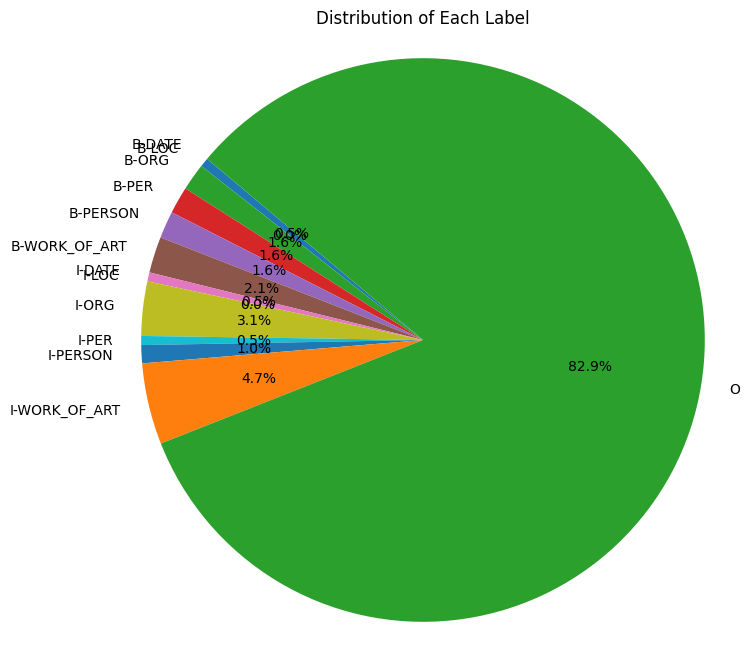

In [58]:


class_labels = ['B-DATE', 'B-LOC', 'B-ORG', 'B-PER', 'B-PERSON', 'B-WORK_OF_ART',
                'I-DATE', 'I-LOC', 'I-ORG', 'I-PER', 'I-PERSON', 'I-WORK_OF_ART', 'O']
supports = [1, 0, 3, 3, 3, 4, 1, 0, 6, 1, 2, 9, 160]

plt.figure(figsize=(8, 8))
plt.pie(supports, labels=class_labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Each Label')
plt.axis('equal')
plt.show()

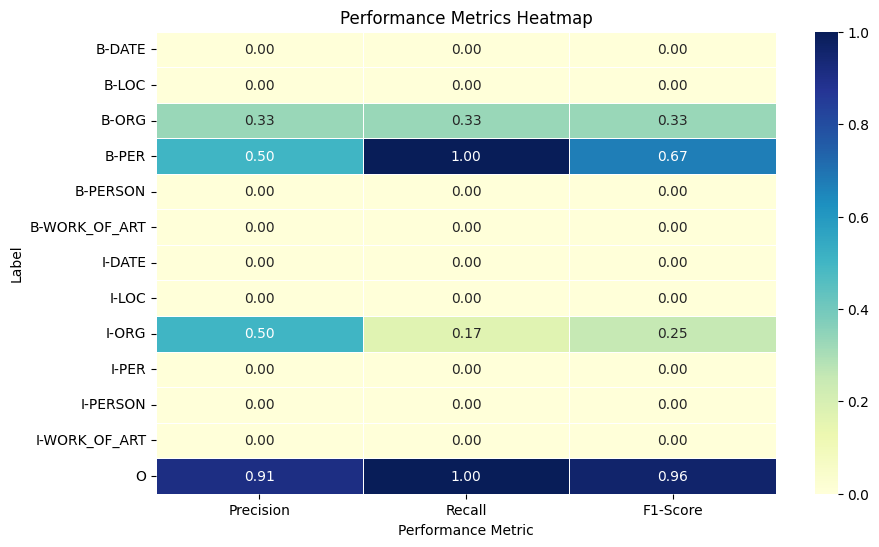

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


data = {
    'Class': ['B-DATE', 'B-LOC', 'B-ORG', 'B-PER', 'B-PERSON', 'B-WORK_OF_ART',
              'I-DATE', 'I-LOC', 'I-ORG', 'I-PER', 'I-PERSON', 'I-WORK_OF_ART', 'O'],
    'Precision': [0.00, 0.00, 0.33, 0.50, 0.00, 0.00, 0.00, 0.00, 0.50, 0.00, 0.00, 0.00, 0.91],
    'Recall': [0.00, 0.00, 0.33, 1.00, 0.00, 0.00, 0.00, 0.00, 0.17, 0.00, 0.00, 0.00, 1.00],
    'F1-Score': [0.00, 0.00, 0.33, 0.67, 0.00, 0.00, 0.00, 0.00, 0.25, 0.00, 0.00, 0.00, 0.96]
}


df = pd.DataFrame(data)


df.set_index('Class', inplace=True)


plt.figure(figsize=(10, 6))
sns.heatmap(df, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=0.5)
plt.title('Performance Metrics Heatmap')
plt.xlabel('Performance Metric')
plt.ylabel('Label')
plt.show()

In [72]:
sentences

["I would n't be caught dead watching the NFL if it were n't for Taylor Swift .",
 "Chris O'Donnell stated that while filming for this movie , he felt like he was in a Toys '' R '' Us commercial .",
 'The whole game was a rollercoaster ride , but Los Angeles Lakers ultimately persevered and won !',
 'Zendaya slayed in Dune 2 , as she does in all her movies .',
 "While my favorite player was playing this match and started off strongggg , it went downhill after Messi 's injyry midgame .",
 "My uncle 's brother 's neighbor 's cat 's veterinarian David reads the communist manifesto in his spare time .",
 'He said that The Great Gatsby is the best novell ever , and I was about to throw hands .',
 'I could not look away from this train wrck of a movie , on February 14th of all days .',
 "The film Everything Everywhere All At Once follows Evelyn Wang , a woman drowning under the stress of her family 's failing laundromat .",
 'I just finished reading pride and prejudice which had me HOOOKED f

In [74]:
nlp = spacy.load("en_core_web_sm")
doc = nlp(sentences[0])
for ent in doc.ents:
    print(ent.text, ent.label_)

displacy.render(doc, jupyter=True, style='ent')

NFL ORG
Taylor Swift PERSON
